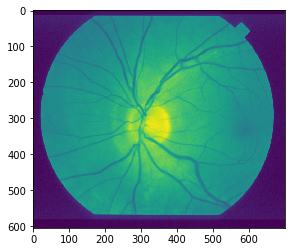

In [1]:

%matplotlib inline
from skimage import color, io, feature, filters, draw
from sklearn import metrics, ensemble
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage.morphology as mp
import functools
import operator
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import os
import imageio

def normalize(img):
    return img / np.max(img)

def calc_contrast(val, lo, hi):
    if val < lo:
        return 0
    if val > hi:
        return 1
    return (val - lo)/(hi - lo)


def contrast_image(img, low, high):
    res = [[calc_contrast(x, low, high) for x in y] for y in img]
    return np.array(res)



def threshold(img, threshpoint):
    return np.array([[1 if x >= threshpoint else 0 for x in y] for y in img])


def apply_mask(img, mask):
    print(np.shape(img))
    print(np.shape(mask))
    res = []
    for i in range(len(img)):
        res.append([])
        for j in range(len(img[i])):
            res[i].append(img[i][j] if mask[i][j] == 0 else 1)
    return np.array(res)

def load_img(img_num, directory):
    if img_num < 10:
        img_num = f"im000{img_num}"
    elif img_num < 100:
        img_num = f"im00{img_num}"
    else:
        img_num = f"im0{img_num}"
    if directory == 'photos':
        return np.array(color.rgb2gray(io.imread(f'stare-images/{img_num}.ppm')))
    elif directory == 'labels':
        return np.array(io.imread(f'labels-vk/{img_num}.vk.ppm'))
    

img_num = 163
img = load_img(img_num, 'photos') #default picture
slice_size = 7
#plt.imshow(img)


In [16]:
#Choose image
directory = 'stare-images'
images = widgets.Dropdown(options=os.listdir(directory))
# Updates the image options based on directory value
def update_images(*args):
    images.options = os.listdir(directory.value)
    
def show_images(file):
    img = imageio.imread(f'stare-images/{file}').astype('uint8')
    plt.imshow(img)
_ = interact(show_images, file=images)

interactive(children=(Dropdown(description='file', options=('im0001.ppm', 'im0002.ppm', 'im0003.ppm', 'im0004.…

In [2]:
#Prepare dataframe
def increase_contrast(img):
    nonzero_photo = img[np.nonzero(img)]
    percentiles = np.percentile(nonzero_photo,(2, 99))
    return contrast_image(img, percentiles[0], percentiles[1])

def detect_edges(img):
    img_sobel = filters.sobel(img)
    perc = np.percentile(img_sobel, (1, 99))
    return contrast_image(img_sobel, perc[0], perc[1])

def apply_morphology(img):
    result = threshold(img, 0.23)
    result = mp.erosion(result, mp.square(2))
    result = mp.dilation(result, mp.square(2))
    return mp.dilation(result, mp.square(2))

def flatten(arr):
    return functools.reduce(operator.iconcat, arr, [])

def print_evaluation_summary(labels, ground_truth):
    cf_mx = metrics.confusion_matrix(ground_truth, labels)
    print("Confusion matrix:")
    print(cf_mx)
    print('Sensitivity: ', cf_mx[1,1]/(cf_mx[1,0] + cf_mx[1,1]))
    print('Specificity: ', cf_mx[0,0]/(cf_mx[0,0] + cf_mx[0,1]))
    print('Accuracy: ', (cf_mx[0,0]+cf_mx[1,1])/sum(flatten(cf_mx)))

def round_to_slice_size(dim):
    return slice_size * ((dim-slice_size) // slice_size)

def slice_image(image, step):
    slices = []

    for r in range(0, round_to_slice_size(image.shape[0]), step):
        for c in range(0, round_to_slice_size(image.shape[1]), step):
            slices.append(image[r:r+slice_size, c:c+slice_size])

    return slices

def to_hu_moments(imgs):
    hu_list = []
    for img in imgs:
        moments = cv2.moments(np.vectorize(float)(img))
        hu_moments = cv2.HuMoments(moments)
        hu_list.append(flatten(hu_moments))
        
    return pd.DataFrame(hu_list)

def reshape_labels(labels, shape):
    return labels.reshape(round_to_slice_size(shape[0]), round_to_slice_size(shape[1]))

def preprocess(img):
    img = normalize(img) 
    img = increase_contrast(img)
    img = detect_edges(img)
    return img

def take_samples(img, step):
    slices = slice_image(img, step)
    slices = [flatten(slice) for slice in slices]
    slices = np.append(slices, to_hu_moments(slices), axis=1)
    return pd.DataFrame(slices)

def label_samples(img, step):
    slices = slice_image(img, step)
    central_pixels = [np.round(slice[slice_size//2][slice_size//2]) for slice in slices]
    return pd.DataFrame(central_pixels)

def prepare_data(i, slice_step):
    x_img = load_img(i, 'photos')
    y_img = load_img(i, 'labels')
    x_img = preprocess(x_img)
    y_img = normalize(y_img)
    samples = take_samples(x_img, slice_step)
    labels = label_samples(y_img, slice_step)
    return samples.assign(label = labels)

def downsample(df):
    minority_count = int(np.sum(df.loc[:, 'label']))
    minority_df = df[df.label == 1]
    majority_df = df[df.label == 0]
    majority_df = resample(majority_df, replace=False, n_samples=minority_count)
    return pd.concat([minority_df, majority_df])

frames = []
training_images = [1,2,3,4,5,44,77,81,82]
for i in training_images:
    df = prepare_data(i, 5)
    df = downsample(df)
    frames.append(df)
training_df = pd.concat(frames)
print(training_df)


             0         1         2         3         4         5         6  \
628   0.764138  0.749453  0.767228  0.794956  0.772586  0.743344  0.776046   
629   0.743344  0.776046  0.848780  0.922138  1.000000  1.000000  0.943535   
645   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
658   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
742   0.141265  0.041287  0.053922  0.100641  0.162972  0.209392  0.289407   
...        ...       ...       ...       ...       ...       ...       ...   
8677  0.120175  0.110799  0.048423  0.058691  0.099106  0.068571  0.028015   
3178  0.093890  0.098994  0.099361  0.096702  0.008443  0.105448  0.057842   
603   0.918705  0.896285  0.960481  1.000000  1.000000  1.000000  0.981109   
2583  0.127454  0.102652  0.084875  0.093293  0.110150  0.098938  0.076335   
3428  0.080745  0.231013  0.107379  0.178699  0.124973  0.016918  0.090153   

             7         8         9  ...        47        48    

In [3]:
#train the classifier
clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=1)
clf.fit(training_df.loc[:, training_df.columns != 'label'], training_df.loc[:,'label'])


scores = cross_val_score(clf, training_df.loc[:, training_df.columns != 'label'], training_df.loc[:,'label'], cv=5, verbose=20, n_jobs=4)
scores

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   23.4s
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:   23.5s remaining:   35.2s
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:   23.8s remaining:   15.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   43.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   43.6s finished


array([0.77539128, 0.74104913, 0.81265612, 0.82064946, 0.83180683])

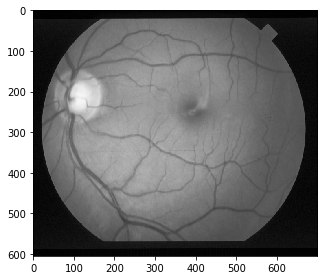

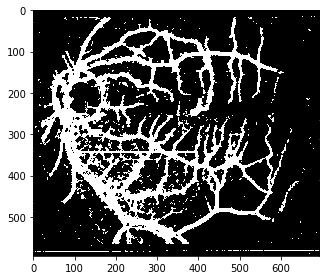

In [26]:
#classify the image
img_num = int(images.value.rstrip('.ppm').lstrip('im0')) #value from interactive box
full_img_df = prepare_data(img_num, 1)
labels = clf.predict(full_img_df.loc[:, full_img_df.columns != 'label'])

full_img_labels = normalize(load_img(img_num, 'labels'))
io.imshow(load_img(img_num, 'photos'))
io.show()
io.imshow(reshape_labels(labels, full_img_labels.shape))

Confusion matrix:
[[304501  51612]
 [ 19084  37138]]
Sensitivity:  0.6605599231617516
Specificity:  0.8550684754558244
Accuracy:  0.8285471764463361
(595, 693)
(595, 693)


True

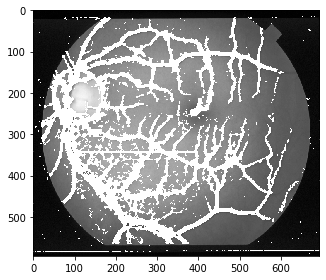

In [27]:
#output to files
clipped_output_img = full_img_labels[:round_to_slice_size(full_img_labels.shape[0]), :round_to_slice_size(full_img_labels.shape[1])]
print_evaluation_summary(labels, flatten(clipped_output_img))
io.imshow(full_img_labels)
labels_output = reshape_labels(labels, full_img_labels.shape)
shape = np.shape(labels_output)
res = apply_mask(load_img(img_num, 'photos')[:shape[0], :shape[1]],labels_output)
io.imshow(res)
cv2.imwrite('expert_mask.jpg', full_img_labels * 255)
cv2.imwrite('output_image.jpg', res * 255)
cv2.imwrite('our_mask.jpg', labels_output * 255)